**Setting up the environment**

In [1]:
#connecting this project to access google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [3]:
!wget https://dlcdn.apache.org/spark/spark-3.3.0/spark-3.3.0-bin-hadoop2.tgz

--2022-10-20 12:03:30--  https://dlcdn.apache.org/spark/spark-3.3.0/spark-3.3.0-bin-hadoop2.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 274079476 (261M) [application/x-gzip]
Saving to: ‘spark-3.3.0-bin-hadoop2.tgz’

spark-3.3.0-bin-had 100%[===================>] 261.38M   101MB/s    in 2.6s    

2022-10-20 12:03:32 (101 MB/s) - ‘spark-3.3.0-bin-hadoop2.tgz’ saved [274079476/274079476]



In [4]:
!tar xf spark-3.3.0-bin-hadoop2.tgz

In [5]:
!pip install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
#this library will be used for the tensorflow: decision tree, random forest, and gradient boosted trees
!pip install tensorflow_decision_forests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.0 MB 4.1 MB/s 
     |████████████████████████████████| 578.0 MB 14 kB/s 
     |████████████████████████████████| 438 kB 55.3 MB/s 
     |████████████████████████████████| 5.9 MB 44.0 MB/s 
     |████████████████████████████████| 1.7 MB 43.3 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.

In [7]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.3.0-bin-hadoop2"

In [8]:
import findspark
findspark.init()

In [9]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local").appName("Colab").config("spark.ui.port",'4050').config('spark.dirver.maxResultSize', '4096').getOrCreate()

**Importing the libraries that will be used**

In [110]:
from pyspark.sql.types import IntegerType, DoubleType, DateType
from pyspark.sql.functions import isnan, when, count, col, lit, to_date
from pyspark.ml.feature import *
from pyspark.ml import Pipeline
from pyspark.mllib.stat import Statistics
from pyspark.ml.stat import Correlation
from pyspark.ml.classification import NaiveBayes, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from keras import backend, metrics
import tensorflow_decision_forests as tfdf
import pyspark.pandas as ps
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow.compat.v1 as tf1
tf1.disable_v2_behavior()
from tensorflow import keras
from sklearn.metrics import classification_report
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

Instructions for updating:
non-resource variables are not supported in the long term


**Take a quick look at the data structure**

In [11]:
#Read the csv file
data = spark.read.csv("/content/drive/MyDrive/CSCI316/data.csv", inferSchema=True, header=True)

In [12]:
#take a look on the first 10 dataset
data.show(10)

+-------+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+--------------------+----------+--------------+----------+-------------------+----------+----------+--------------------+------------------+--------------------+--------+----------+-----+-----------+----------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+----------------+------+-----------+---------

In [13]:
#get the percentage of null values 
amount_missing_df = data.select([((count(when(col(c).isNull(), c))/data.count())*100).alias(c) for c in data.columns])
amount_missing_df.show()

+---+---------+---------+-----------+---------------+----+--------+-----------+-----+---------+------------------+----------+--------------+----------+-------------------+-------+----------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------------+----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------------+------------------+--------------------+-----------------+--------------------+--------------------------+---------------------------+--------------------+--------------------+----------------+-----------------+-------------------------+--------------------+--

In [14]:
#Show the types
data.dtypes

[('id', 'int'),
 ('member_id', 'int'),
 ('loan_amnt', 'int'),
 ('funded_amnt', 'int'),
 ('funded_amnt_inv', 'double'),
 ('term', 'string'),
 ('int_rate', 'double'),
 ('installment', 'double'),
 ('grade', 'string'),
 ('sub_grade', 'string'),
 ('emp_title', 'string'),
 ('emp_length', 'string'),
 ('home_ownership', 'string'),
 ('annual_inc', 'string'),
 ('verification_status', 'string'),
 ('issue_d', 'string'),
 ('pymnt_plan', 'string'),
 ('desc', 'string'),
 ('purpose', 'string'),
 ('title', 'string'),
 ('zip_code', 'string'),
 ('addr_state', 'string'),
 ('dti', 'string'),
 ('delinq_2yrs', 'string'),
 ('earliest_cr_line', 'string'),
 ('inq_last_6mths', 'string'),
 ('mths_since_last_delinq', 'string'),
 ('mths_since_last_record', 'string'),
 ('open_acc', 'string'),
 ('pub_rec', 'string'),
 ('revol_bal', 'string'),
 ('revol_util', 'string'),
 ('total_acc', 'string'),
 ('initial_list_status', 'string'),
 ('out_prncp', 'string'),
 ('out_prncp_inv', 'string'),
 ('total_pymnt', 'string'),
 ('t

In [15]:
#delete the row that has null value in default_ind
delete_default_ind_null = data.filter(data.default_ind.isNotNull())
delete_default_ind_null.select([count(when(col(c).isNull(), c)).alias(c) for c in delete_default_ind_null.columns]).show()

+---+---------+---------+-----------+---------------+----+--------+-----------+-----+---------+---------+----------+--------------+----------+-------------------+-------+----------+------+-------+-----+--------+----------+---+-----------+----------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+----------------+------+-----------+------------+-----------+
| id|member_id|loan_amnt|funded_amnt|funded_amnt_

In [16]:
#Deal with outliers
def find_outliers(df):

    # Identifying the numerical columns in a spark dataframe
    numeric_columns = [column[0] for column in df.dtypes if column[1]=='int']

    # Using the `for` loop to create new columns by identifying the outliers for each feature
    for column in numeric_columns:

        less_Q1 = 'less_Q1_{}'.format(column)
        more_Q3 = 'more_Q3_{}'.format(column)
        Q1 = 'Q1_{}'.format(column)
        Q3 = 'Q3_{}'.format(column)

        # Q1 : First Quartile ., Q3 : Third Quartile
        Q1 = df.approxQuantile(column,[0.25],relativeError=0)
        Q3 = df.approxQuantile(column,[0.75],relativeError=0)
        
        # IQR : Inter Quantile Range
        # We need to define the index [0], as Q1 & Q3 are a set of lists., to perform a mathematical operation
        # Q1 & Q3 are defined seperately so as to have a clear indication on First Quantile & 3rd Quantile
        IQR = Q3[0] - Q1[0]
        
        #selecting the data, with -1.5*IQR to + 1.5*IQR., where param = 1.5 default value
        less_Q1 =  Q1[0] - 1.5*IQR
        more_Q3 =  Q3[0] + 1.5*IQR
        
        isOutlierCol = 'is_outlier_{}'.format(column)
        
        df = df.withColumn(isOutlierCol, when((df[column] > more_Q3) | (df[column] < less_Q1), 1).otherwise(0))
    

    # Selecting the specific columns which we have added above, to check if there are any outliers
    selected_columns = [column for column in df.columns if column.startswith("is_outlier")]

    # Adding all the outlier columns into a new colum "total_outliers", to see the total number of outliers
    df = df.withColumn('total_outliers',sum(df[column] for column in selected_columns))

    # Dropping the extra columns created above, just to create nice dataframe., without extra columns
    df = df.drop(*[column for column in df.columns if column.startswith("is_outlier")])

    return df

In [17]:
#create a new dataframe that has a column with the total of outliers in each row
new_data = find_outliers(delete_default_ind_null)
new_data.show()

#filter it by taking only the data with less than one outlier
new_data_with_no_outliers = new_data.filter(new_data['total_Outliers']<=1)
new_data_with_no_outliers = new_data_with_no_outliers.select(*data.columns)



+-------+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+--------------------+----------+--------------+----------+-------------------+----------+----------+--------------------+------------------+--------------------+--------+----------+-----+-----------+----------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+----------------+------+-----------+---------

In [18]:
#counting the total data after we remove the outliers
new_data_with_no_outliers.count()

855746

In [19]:
#showing what it looks like now
new_data_with_no_outliers.show()

+-------+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+--------------------+----------+--------------+----------+-------------------+----------+----------+--------------------+------------------+--------------------+--------+----------+-----+-----------+----------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+----------------+------+-----------+---------

**Selecting only several useful features**

In [20]:
#Here are the columns that will be dropped because they havw null values more than 40% or it is just string
cols = ("desc", "mths_since_last_delinq", "mths_since_last_record", "mths_since_last_major_derog", "annual_inc_joint", "dti_joint", "verification_status_joint", "open_acc_6m", "open_il_6m", "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il", "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc", "all_util", "inq_fi", "total_cu_tl", "inq_last_12m","emp_title","title","zip_code","earliest_cr_line","issue_d","last_pymnt_d","next_pymnt_d","last_credit_pull_d","addr_state")
droppedColumns = new_data_with_no_outliers.drop(*cols)

In [21]:
len(droppedColumns.columns)

43

In [22]:
droppedColumns.printSchema()

root
 |-- id: integer (nullable = true)
 |-- member_id: integer (nullable = true)
 |-- loan_amnt: integer (nullable = true)
 |-- funded_amnt: integer (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- dti: string (nullable = true)
 |-- delinq_2yrs: string (nullable = true)
 |-- inq_last_6mths: string (nullable = true)
 |-- open_acc: string (nullable = true)
 |-- pub_rec: string (nullable = true)
 |-- revol_bal: string (nullable = true)
 |-- revol_util: string (nullable = true)
 |-- total_acc: string (nullable = true)

In [23]:
#get the percentage of null values 
amount_missing_df = droppedColumns.select([((count(when(col(c).isNull(), c))/droppedColumns.count())*100).alias(c) for c in droppedColumns.columns])
amount_missing_df.show()

+---+---------+---------+-----------+---------------+----+--------+-----------+-----+---------+----------+--------------+----------+-------------------+----------+-------+---+-----------+--------------+--------+-------+---------+-------------------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+--------------------+--------------------------+--------------------+--------------------+--------------+-----------------+-----------------+------------------+-----------+
| id|member_id|loan_amnt|funded_amnt|funded_amnt_inv|term|int_rate|installment|grade|sub_grade|emp_length|home_ownership|annual_inc|verification_status|pymnt_plan|purpose|dti|delinq_2yrs|inq_last_6mths|open_acc|pub_rec|revol_bal|         revol_util|total_acc|initial_list_status|out_prncp|out_prncp_inv|total_pymnt|total_pymnt_inv|total_rec_prncp|total_rec_int|total_rec_late_fee|recoveries|collection_recovery_f

**Cast column types**

In [24]:
#Here, since there is null value or outliers, the values are in string. 
#Then, we convert the type to the desired data type
convertedDf = droppedColumns.withColumn("revol_util", col("revol_util").cast(DoubleType())) \
.withColumn("last_pymnt_amnt", col("last_pymnt_amnt").cast(DoubleType())) \
.withColumn("collections_12_mths_ex_med", col("collections_12_mths_ex_med").cast(IntegerType())) \
.withColumn("policy_code", col("policy_code").cast(IntegerType())) \
.withColumn("tot_coll_amt", col("tot_coll_amt").cast(IntegerType())) \
.withColumn("tot_cur_bal", col("tot_cur_bal").cast(IntegerType())) \
.withColumn("total_rev_hi_lim", col("total_rev_hi_lim").cast(IntegerType()))\


In [25]:
#get the data type for each column
convertedDf.printSchema()

root
 |-- id: integer (nullable = true)
 |-- member_id: integer (nullable = true)
 |-- loan_amnt: integer (nullable = true)
 |-- funded_amnt: integer (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- dti: string (nullable = true)
 |-- delinq_2yrs: string (nullable = true)
 |-- inq_last_6mths: string (nullable = true)
 |-- open_acc: string (nullable = true)
 |-- pub_rec: string (nullable = true)
 |-- revol_bal: string (nullable = true)
 |-- revol_util: double (nullable = true)
 |-- total_acc: string (nullable = true)

In [26]:
#since there are some missing values, then we have to impute it.

imputerDouble = ["revol_util","last_pymnt_amnt"]
imputerInteger = ["collections_12_mths_ex_med","policy_code","tot_coll_amt","tot_cur_bal","total_rev_hi_lim"]

In [27]:
#impute the missing values for column in imputerDOuble with the mean of those column

#as the output, it will make a new column
imputer = Imputer(inputCols = imputerDouble, outputCols=["{}_imputed".format(c) for c in imputerDouble]) 
modelDouble = imputer.fit(convertedDf)
modelDouble.getStrategy()

'mean'

In [28]:
#transform the dataframe with the imputer for float
imputedDoubleCol = modelDouble.transform(convertedDf)
imputedDoubleCol.show()

+-------+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+----------+--------------+----------+-------------------+----------+------------------+-----+-----------+--------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+---------------+--------------------------+-----------+----------------+--------------+------------+-----------+----------------+-----------+------------------+-----------------------+
|     id|member_id|loan_amnt|funded_amnt|funded_amnt_inv|      term|int_rate|installment|grade|sub_grade|emp_length|home_ownership|annual_inc|verification_status|pymnt_plan|           purpose|  dti|delinq_2yrs|inq_last_6mths|open_acc|pub_rec|revol_bal|revol_util|total_acc|initial_list_status|out_prncp|out_prncp_inv|total_pymnt|total_pymnt_inv|total_rec_prncp|total_rec_int|total_rec_l

In [29]:
#Do the same thing for the column in Integer 
#the strategy is median for the int column
imputer2 = Imputer(inputCols = imputerInteger, outputCols=["{}_imputed".format(c) for c in imputerInteger])
modelInteger = imputer2.setStrategy("median").fit(imputedDoubleCol)
modelInteger.getStrategy()

'median'

In [30]:
#Make the transformation
imputedIntCol = modelInteger.transform(imputedDoubleCol)
imputedIntCol.show()

+-------+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+----------+--------------+----------+-------------------+----------+------------------+-----+-----------+--------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+---------------+--------------------------+-----------+----------------+--------------+------------+-----------+----------------+-----------+------------------+-----------------------+----------------------------------+-------------------+--------------------+-------------------+------------------------+
|     id|member_id|loan_amnt|funded_amnt|funded_amnt_inv|      term|int_rate|installment|grade|sub_grade|emp_length|home_ownership|annual_inc|verification_status|pymnt_plan|           purpose|  dti|delinq_2yrs|inq_last_6mths|open_acc|pub_rec|revol_bal|revol_util|to

In [31]:
#see the unique value of application type
imputedIntCol.groupby("application_type").count().show()

+----------------+------+
|application_type| count|
+----------------+------+
|            null|     2|
|              32|     1|
|      INDIVIDUAL|855301|
|           JOINT|   442|
+----------------+------+



In [32]:
#change the null value of the application_type to INDIVIDUAL 
#INDIVIDUAL is the Mode of column application_type
#do it in manual way

#replace null with individual
fixedApplicationType = imputedIntCol.withColumn("application_type", when (imputedIntCol["application_type"].isNull(), lit("INDIVIDUAL")).otherwise(imputedIntCol["application_type"]) )
#replace the 32 with individual also
fixedApplicationType32 = fixedApplicationType.withColumn("application_type", when (fixedApplicationType["application_type"] == 32, lit("INDIVIDUAL")).otherwise(fixedApplicationType["application_type"]) )

In [33]:
fixedApplicationType32.groupby('application_type').count().show()

+----------------+------+
|application_type| count|
+----------------+------+
|      INDIVIDUAL|855304|
|           JOINT|   442|
+----------------+------+



In [34]:
#check for the missing values
fixedApplicationType32.select([count(when(col(c).isNull(), c)).alias(c) for c in fixedApplicationType32.columns]).show()

+---+---------+---------+-----------+---------------+----+--------+-----------+-----+---------+----------+--------------+----------+-------------------+----------+-------+---+-----------+--------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+---------------+--------------------------+-----------+----------------+--------------+------------+-----------+----------------+-----------+------------------+-----------------------+----------------------------------+-------------------+--------------------+-------------------+------------------------+
| id|member_id|loan_amnt|funded_amnt|funded_amnt_inv|term|int_rate|installment|grade|sub_grade|emp_length|home_ownership|annual_inc|verification_status|pymnt_plan|purpose|dti|delinq_2yrs|inq_last_6mths|open_acc|pub_rec|revol_bal|revol_util|total_acc|initial_list_status|out_prncp|out_prnc

In [35]:
#Delete the columns because we already have the new one that has been cleaned
deleteImputedNumber = ("revol_util","last_pymnt_amnt","collections_12_mths_ex_med","policy_code","tot_coll_amt","tot_cur_bal","total_rev_hi_lim")

imputedDf = fixedApplicationType32.drop(*deleteImputedNumber)

imputedDf.show()


+-------+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+----------+--------------+----------+-------------------+----------+------------------+-----+-----------+--------------+--------+-------+---------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+----------------+--------------+-----------+------------------+-----------------------+----------------------------------+-------------------+--------------------+-------------------+------------------------+
|     id|member_id|loan_amnt|funded_amnt|funded_amnt_inv|      term|int_rate|installment|grade|sub_grade|emp_length|home_ownership|annual_inc|verification_status|pymnt_plan|           purpose|  dti|delinq_2yrs|inq_last_6mths|open_acc|pub_rec|revol_bal|total_acc|initial_list_status|out_prncp|out_prncp_inv|total_pymnt|total_pymnt_inv|total_rec_prncp|total_rec_int|total_rec

In [36]:
#drop the null value if it is exist
cleanDf = imputedDf.na.drop()

In [37]:
#check for the missing value again
cleanDf.select([count(when(col(c).isNull(), c)).alias(c) for c in cleanDf.columns]).show()

+---+---------+---------+-----------+---------------+----+--------+-----------+-----+---------+----------+--------------+----------+-------------------+----------+-------+---+-----------+--------------+--------+-------+---------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+----------------+--------------+-----------+------------------+-----------------------+----------------------------------+-------------------+--------------------+-------------------+------------------------+
| id|member_id|loan_amnt|funded_amnt|funded_amnt_inv|term|int_rate|installment|grade|sub_grade|emp_length|home_ownership|annual_inc|verification_status|pymnt_plan|purpose|dti|delinq_2yrs|inq_last_6mths|open_acc|pub_rec|revol_bal|total_acc|initial_list_status|out_prncp|out_prncp_inv|total_pymnt|total_pymnt_inv|total_rec_prncp|total_rec_int|total_rec_late_fee|recoveries|collection_recovery_fee|a

In [38]:
#the total number of rows that we have after cleaning process
cleanDf.count()

855746

In [39]:
cleanDf.show()

+-------+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+----------+--------------+----------+-------------------+----------+------------------+-----+-----------+--------------+--------+-------+---------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+----------------+--------------+-----------+------------------+-----------------------+----------------------------------+-------------------+--------------------+-------------------+------------------------+
|     id|member_id|loan_amnt|funded_amnt|funded_amnt_inv|      term|int_rate|installment|grade|sub_grade|emp_length|home_ownership|annual_inc|verification_status|pymnt_plan|           purpose|  dti|delinq_2yrs|inq_last_6mths|open_acc|pub_rec|revol_bal|total_acc|initial_list_status|out_prncp|out_prncp_inv|total_pymnt|total_pymnt_inv|total_rec_prncp|total_rec_int|total_rec

**Converting the categorical features**

In [40]:
#here are the columns that can be converted to categorical
categoricalColumns = ("term","grade","sub_grade","emp_length","home_ownership","verification_status","pymnt_plan","initial_list_status","application_type","purpose","acc_now_delinq")

In [41]:
#By using this pipeline, we convert the string to the categorical
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(cleanDf) for column in list(set(cleanDf.columns)-set(['id','member_id','loan_amnt','funded_amnt','funded_amnt_inv','int_rate','installment','emp_title','annual_inc','issue_d','title','zip_code','dti','delinq_2yrs','earliest_cr_line','inq_last_6mths','open_acc','pub_rec','revol_bal','total_acc','out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_d','next_pymnt_d','last_credit_pull_d','cc_now_delinq','default_ind','revol_util_imputed','last_pymnt_amnt_imputed','collections_12_mths_ex_med_imputed','policy_code_imputed','tot_coll_amt_imputed','tot_cur_bal_imputed','total_rev_hi_lim_imputed'])) ]

pipeline = Pipeline(stages=indexers)

df_r = pipeline.fit(cleanDf).transform(cleanDf)

df_r.show()


+-------+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+----------+--------------+----------+-------------------+----------+------------------+-----+-----------+--------------+--------+-------+---------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+----------------+--------------+-----------+------------------+-----------------------+----------------------------------+-------------------+--------------------+-------------------+------------------------+-----------+-------------------------+----------------+-------------------------+--------------------+--------------------+-------------+---------------+----------------------+----------+----------------+
|     id|member_id|loan_amnt|funded_amnt|funded_amnt_inv|      term|int_rate|installment|grade|sub_grade|emp_length|home_ownership|annual_inc|verification_status|pymnt_p

In [42]:
#delete the actual columns

categorical_df = df_r.drop(*categoricalColumns)
categorical_df.show()

+-------+---------+---------+-----------+---------------+--------+-----------+----------+-----+-----------+--------------+--------+-------+---------+---------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+-----------+------------------+-----------------------+----------------------------------+-------------------+--------------------+-------------------+------------------------+-----------+-------------------------+----------------+-------------------------+--------------------+--------------------+-------------+---------------+----------------------+----------+----------------+
|     id|member_id|loan_amnt|funded_amnt|funded_amnt_inv|int_rate|installment|annual_inc|  dti|delinq_2yrs|inq_last_6mths|open_acc|pub_rec|revol_bal|total_acc|out_prncp|out_prncp_inv|total_pymnt|total_pymnt_inv|total_rec_prncp|total_rec_int|total_rec_late_fee|recoveries|collection_recovery_fee|default_ind|revol_util_impute

In [43]:
len(categorical_df.columns)

43

In [44]:
#As it can be seen, there are some columns that still in string
categorical_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- member_id: integer (nullable = true)
 |-- loan_amnt: integer (nullable = true)
 |-- funded_amnt: integer (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- dti: string (nullable = true)
 |-- delinq_2yrs: string (nullable = true)
 |-- inq_last_6mths: string (nullable = true)
 |-- open_acc: string (nullable = true)
 |-- pub_rec: string (nullable = true)
 |-- revol_bal: string (nullable = true)
 |-- total_acc: string (nullable = true)
 |-- out_prncp: string (nullable = true)
 |-- out_prncp_inv: string (nullable = true)
 |-- total_pymnt: string (nullable = true)
 |-- total_pymnt_inv: string (nullable = true)
 |-- total_rec_prncp: string (nullable = true)
 |-- total_rec_int: string (nullable = true)
 |-- total_rec_late_fee: string (nullable = true)
 |-- recoveries: string (nullable = true)
 |-- collection

In [45]:
#convert them to the desired data types
categorical_df = categorical_df.withColumn("annual_inc", categorical_df["annual_inc"].cast(IntegerType()))\
.withColumn("delinq_2yrs",categorical_df["delinq_2yrs"].cast(IntegerType()))\
.withColumn("inq_last_6mths",categorical_df["inq_last_6mths"].cast(IntegerType()))\
.withColumn("open_acc",categorical_df["open_acc"].cast(IntegerType()))\
.withColumn("pub_rec",categorical_df["pub_rec"].cast(IntegerType()))\
.withColumn("revol_bal",categorical_df["revol_bal"].cast(IntegerType()))\
.withColumn("total_acc",categorical_df["total_acc"].cast(IntegerType()))\
.withColumn("out_prncp",categorical_df["out_prncp"].cast(DoubleType()))\
.withColumn("out_prncp_inv",categorical_df["out_prncp_inv"].cast(DoubleType()))\
.withColumn("total_pymnt",categorical_df["total_pymnt"].cast(DoubleType()))\
.withColumn("total_pymnt_inv",categorical_df["total_pymnt_inv"].cast(DoubleType()))\
.withColumn("total_rec_prncp",categorical_df["total_rec_prncp"].cast(DoubleType()))\
.withColumn("total_rec_int",categorical_df["total_rec_int"].cast(DoubleType()))\
.withColumn("recoveries",categorical_df["recoveries"].cast(DoubleType()))\
.withColumn("total_rec_late_fee",categorical_df["total_rec_late_fee"].cast(DoubleType()))\
.withColumn("collection_recovery_fee",categorical_df["collection_recovery_fee"].cast(DoubleType()))\
.withColumn("dti",categorical_df["dti"].cast(DoubleType()))\



In [46]:
#get the information regarding the dataset
categorical_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- member_id: integer (nullable = true)
 |-- loan_amnt: integer (nullable = true)
 |-- funded_amnt: integer (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- annual_inc: integer (nullable = true)
 |-- dti: double (nullable = true)
 |-- delinq_2yrs: integer (nullable = true)
 |-- inq_last_6mths: integer (nullable = true)
 |-- open_acc: integer (nullable = true)
 |-- pub_rec: integer (nullable = true)
 |-- revol_bal: integer (nullable = true)
 |-- total_acc: integer (nullable = true)
 |-- out_prncp: double (nullable = true)
 |-- out_prncp_inv: double (nullable = true)
 |-- total_pymnt: double (nullable = true)
 |-- total_pymnt_inv: double (nullable = true)
 |-- total_rec_prncp: double (nullable = true)
 |-- total_rec_int: double (nullable = true)
 |-- total_rec_late_fee: double (nullable = true)
 |-- recoveries: double (nullable = true)
 |-- col

In [47]:
#check for the missing values
categorical_df.select([count(when(col(c).isNull(), c)).alias(c) for c in categorical_df.columns]).show()

+---+---------+---------+-----------+---------------+--------+-----------+----------+---+-----------+--------------+--------+-------+---------+---------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+-----------+------------------+-----------------------+----------------------------------+-------------------+--------------------+-------------------+------------------------+-----------+-------------------------+----------------+-------------------------+--------------------+--------------------+-------------+---------------+----------------------+----------+----------------+
| id|member_id|loan_amnt|funded_amnt|funded_amnt_inv|int_rate|installment|annual_inc|dti|delinq_2yrs|inq_last_6mths|open_acc|pub_rec|revol_bal|total_acc|out_prncp|out_prncp_inv|total_pymnt|total_pymnt_inv|total_rec_prncp|total_rec_int|total_rec_late_fee|recoveries|collection_recovery_fee|default_ind|revol_util_imputed|last_pymnt

In [48]:
#re-order the columns 
arranged_columns = categorical_df.select("id","member_id","loan_amnt","funded_amnt","funded_amnt_inv","int_rate","installment","annual_inc",
                             "dti","delinq_2yrs","inq_last_6mths","open_acc","pub_rec","revol_bal","total_acc","out_prncp","out_prncp_inv",
                             "total_pymnt","total_pymnt_inv","total_rec_prncp","total_rec_int","total_rec_late_fee","recoveries",
                             "collection_recovery_fee","revol_util_imputed","last_pymnt_amnt_imputed","collections_12_mths_ex_med_imputed",
                             "policy_code_imputed","tot_coll_amt_imputed","tot_cur_bal_imputed","total_rev_hi_lim_imputed","pymnt_plan_index",
                             "application_type_index","acc_now_delinq_index","grade_index","purpose_index","home_ownership_index",
                             "emp_length_index","verification_status_index","sub_grade_index","term_index","initial_list_status_index", "default_ind")

In [49]:
final_dataset = arranged_columns.na.drop()

In [50]:
#check for the missing values
final_dataset.select([count(when(col(c).isNull(), c)).alias(c) for c in final_dataset.columns]).show()

+---+---------+---------+-----------+---------------+--------+-----------+----------+---+-----------+--------------+--------+-------+---------+---------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+------------------+-----------------------+----------------------------------+-------------------+--------------------+-------------------+------------------------+----------------+----------------------+--------------------+-----------+-------------+--------------------+----------------+-------------------------+---------------+----------+-------------------------+-----------+
| id|member_id|loan_amnt|funded_amnt|funded_amnt_inv|int_rate|installment|annual_inc|dti|delinq_2yrs|inq_last_6mths|open_acc|pub_rec|revol_bal|total_acc|out_prncp|out_prncp_inv|total_pymnt|total_pymnt_inv|total_rec_prncp|total_rec_int|total_rec_late_fee|recoveries|collection_recovery_fee|revol_util_imputed|last_pymnt_amnt_impute

In [51]:
#final_dataset.repartition(1).write.csv("/content/drive/MyDrive/CSCI316/CleanWithHeader2.csv",header = 'true')

**Getting the correlation between each column**

In [52]:
# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=final_dataset.columns, outputCol=vector_col)
df_vector = assembler.transform(final_dataset).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

In [53]:
#plotting the correlation between each column
matrix = Correlation.corr(df_vector, "corr_features").collect()[0][0] 
corr_matrix = matrix.toArray().tolist() 
corr_matrix_df = pd.DataFrame(data=corr_matrix) 
corr_matrix_df .style.background_gradient(cmap='coolwarm').set_precision(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  after removing the cwd from sys.path.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42
0,1.00,1.00,0.06,0.07,0.07,-0.14,0.02,0.03,0.07,0.05,-0.12,0.09,0.08,0.04,0.03,0.56,0.56,-0.59,-0.59,-0.55,-0.46,-0.08,-0.12,-0.07,-0.05,-0.23,0.05,nan,0.01,0.05,0.07,-0.00,0.03,0.02,0.00,-0.06,0.02,-0.02,-0.10,0.00,0.07,0.37,-0.22
1,1.00,1.00,0.06,0.07,0.07,-0.14,0.02,0.03,0.07,0.05,-0.12,0.09,0.08,0.04,0.03,0.56,0.56,-0.59,-0.59,-0.55,-0.46,-0.08,-0.12,-0.07,-0.05,-0.23,0.05,nan,0.01,0.05,0.07,-0.00,0.03,0.02,0.00,-0.06,0.02,-0.02,-0.10,0.00,0.07,0.37,-0.22
2,0.06,0.06,1.00,1.00,1.00,0.14,0.94,0.34,0.02,-0.00,-0.03,0.20,-0.08,0.34,0.22,0.64,0.64,0.48,0.48,0.40,0.54,0.03,0.08,0.06,0.12,0.23,-0.02,nan,-0.00,0.32,0.31,0.00,0.01,0.00,0.15,-0.17,-0.15,-0.07,-0.20,0.14,0.41,0.09,-0.00
3,0.07,0.07,1.00,1.00,1.00,0.14,0.95,0.34,0.02,-0.00,-0.03,0.20,-0.08,0.34,0.22,0.64,0.64,0.48,0.48,0.39,0.54,0.03,0.08,0.06,0.12,0.23,-0.02,nan,-0.00,0.33,0.31,0.00,0.01,0.00,0.15,-0.17,-0.15,-0.07,-0.20,0.14,0.41,0.09,-0.01
4,0.07,0.07,1.00,1.00,1.00,0.14,0.94,0.33,0.02,0.00,-0.03,0.20,-0.08,0.34,0.22,0.64,0.64,0.47,0.48,0.39,0.53,0.02,0.07,0.05,0.12,0.23,-0.02,nan,-0.00,0.33,0.31,0.00,0.01,0.00,0.15,-0.17,-0.15,-0.06,-0.20,0.14,0.41,0.09,-0.01
5,-0.14,-0.14,0.14,0.14,0.14,1.00,0.13,-0.07,0.08,0.06,0.23,-0.01,0.05,-0.04,-0.04,0.03,0.03,0.17,0.17,0.06,0.45,0.05,0.11,0.07,0.27,0.11,0.01,nan,0.00,-0.08,-0.16,0.00,0.01,0.03,0.63,0.05,0.05,0.01,-0.12,0.46,0.43,-0.12,0.16
6,0.02,0.02,0.94,0.95,0.94,0.13,1.00,0.33,0.01,0.01,0.00,0.18,-0.07,0.32,0.20,0.54,0.54,0.52,0.52,0.46,0.50,0.04,0.08,0.06,0.13,0.24,-0.01,nan,-0.00,0.29,0.28,0.00,0.01,0.01,0.14,-0.15,-0.13,-0.06,-0.17,0.14,0.14,0.03,0.00
7,0.03,0.03,0.34,0.34,0.33,-0.07,0.33,1.00,-0.09,0.05,0.04,0.14,-0.01,0.30,0.19,0.21,0.21,0.16,0.16,0.15,0.13,0.01,0.01,0.01,0.04,0.09,-0.00,nan,0.00,0.41,0.26,0.00,-0.01,0.02,-0.01,0.01,-0.13,-0.06,-0.08,0.02,0.06,0.04,-0.04
8,0.07,0.07,0.02,0.02,0.02,0.08,0.01,-0.09,1.00,-0.00,-0.01,0.14,-0.02,0.07,0.11,0.06,0.06,-0.04,-0.04,-0.05,0.01,-0.01,0.00,0.00,0.09,-0.03,-0.00,nan,-0.00,-0.00,0.04,0.00,0.08,0.00,0.04,-0.06,0.01,0.00,-0.01,0.02,0.05,0.02,0.00
9,0.05,0.05,-0.00,-0.00,0.00,0.06,0.01,0.05,-0.00,1.00,0.02,0.05,-0.01,-0.03,0.12,0.03,0.03,-0.03,-0.03,-0.04,0.00,0.01,-0.00,0.00,-0.02,-0.02,0.06,nan,0.00,0.07,-0.04,0.00,0.00,0.13,0.01,0.00,-0.04,-0.03,-0.01,-0.01,-0.00,0.02,-0.01


**Data Exploration**

This phase has been done in different .ipynb files because google colab has limit on RAM

In [55]:
# from pandas.plotting import scatter_matrix
# final_dataset_pandas = final_dataset.toPandas()

In [56]:
# scatter_matrix(final_dataset_pandas, figsize=(12, 8))

# Building the Model

## using PySpark 



In [57]:
#declaring the feature column first
features = ["id","member_id","loan_amnt","funded_amnt","funded_amnt_inv","int_rate","installment","annual_inc",
                             "dti","delinq_2yrs","inq_last_6mths","open_acc","pub_rec","revol_bal","total_acc","out_prncp","out_prncp_inv",
                             "total_pymnt","total_pymnt_inv","total_rec_prncp","total_rec_int","total_rec_late_fee","recoveries",
                             "collection_recovery_fee","revol_util_imputed","last_pymnt_amnt_imputed","collections_12_mths_ex_med_imputed",
                             "policy_code_imputed","tot_coll_amt_imputed","tot_cur_bal_imputed","total_rev_hi_lim_imputed","pymnt_plan_index",
                             "application_type_index","acc_now_delinq_index","grade_index","purpose_index","home_ownership_index",
                             "emp_length_index","verification_status_index","sub_grade_index","term_index","initial_list_status_index"]

In [58]:
# Merge all feature columns for prediction into a vector column
vector_assembler = VectorAssembler(inputCols =features, outputCol="features")
#transform the dataset
vectorized_df = vector_assembler.transform(final_dataset)
vectorized_df = vectorized_df.select(['features', 'default_ind'])

#why we need this?
#because pyspark ML only supports vector for the features
vectorized_df.show()

+--------------------+-----------+
|            features|default_ind|
+--------------------+-----------+
|(42,[0,1,2,3,4,5,...|          0|
|[1077430.0,131416...|          1|
|[1077175.0,131352...|          0|
|[1076863.0,127717...|          0|
|[1075358.0,131174...|          0|
|[1075269.0,131144...|          0|
|[1069639.0,130474...|          0|
|[1072053.0,128868...|          0|
|[1071795.0,130695...|          1|
|[1071570.0,130672...|          1|
|[1070078.0,130520...|          0|
|(42,[0,1,2,3,4,5,...|          0|
|[1064687.0,129871...|          1|
|(42,[0,1,2,3,4,5,...|          0|
|[1069057.0,130350...|          1|
|[1069759.0,130487...|          0|
|[1065775.0,129969...|          0|
|(42,[0,1,2,3,4,5,...|          0|
|(42,[0,1,2,3,4,5,...|          0|
|(42,[0,1,2,3,4,5,...|          0|
+--------------------+-----------+
only showing top 20 rows



In [59]:
#set the seed for the splitting the dataset
seed = 142
train_df, test_df = vectorized_df.randomSplit([0.7,0.3], seed)

In [60]:
#Create evaluation function, later on it will be used in the end of each model

def common_metrics_pyspark(predictions):
  evaluator_accuracy = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="default_ind", metricName="accuracy")
  accuracy = evaluator_accuracy.evaluate(predictions)
  evaluator_precision = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="default_ind", metricName="precisionByLabel")
  precision = evaluator_precision.evaluate(predictions)
  evaluator_f1 = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="default_ind", metricName="f1")
  f1 = evaluator_f1.evaluate(predictions)
  evaluator_recall = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="default_ind", metricName="recallByLabel")
  recall = evaluator_recall.evaluate(predictions)
  print("accuracy: ", accuracy)
  print("precision: ", precision)
  print("recall: ", recall)
  print("f1: ", f1)


### 1. Naive Bayes

In [61]:
#Train Naive Bayes model

#for the featuresCol, it can only take one input and it must be in vector
#labelCol is the target
#using multinomial naive bayes because it calculates the likelihood of each tag and will choose the largest probability
nb = NaiveBayes(modelType="multinomial", featuresCol="features", labelCol="default_ind")

#fitting the train data to the model
nb_model = nb.fit(train_df)

In [62]:
#Make predictions
nb_pred  = nb_model.transform(test_df)
nb_pred.show(3)

+--------------------+-----------+--------------------+-----------+----------+
|            features|default_ind|       rawPrediction|probability|prediction|
+--------------------+-----------+--------------------+-----------+----------+
|(42,[0,1,2,3,4,5,...|          0|[-1.4700841482635...|  [0.0,1.0]|       1.0|
|(42,[0,1,2,3,4,5,...|          0|[-1.4749527025860...|  [0.0,1.0]|       1.0|
|(42,[0,1,2,3,4,5,...|          0|[-2925435.6760308...|  [0.0,1.0]|       1.0|
+--------------------+-----------+--------------------+-----------+----------+
only showing top 3 rows



In [63]:
#getting the accuracy, precision, recall and f1-score
common_metrics_pyspark(nb_pred)

accuracy:  0.6576263932927422
precision:  0.9787265557016164
recall:  0.6522388243858502
f1:  0.7508615881273103


### 2. Decision Tree

In [64]:
#build the model for decision tree 
dt = DecisionTreeClassifier(maxDepth=2, labelCol="default_ind", maxBins=40)

In [65]:
#fit the model with the training data
dt_model = dt.fit(train_df)

In [66]:
#Make predictions
pred_dt = dt_model.transform(test_df)
pred_dt.show(3)

+--------------------+-----------+------------------+--------------------+----------+
|            features|default_ind|     rawPrediction|         probability|prediction|
+--------------------+-----------+------------------+--------------------+----------+
|(42,[0,1,2,3,4,5,...|          0|[566168.0,15618.0]|[0.97315507764023...|       0.0|
|(42,[0,1,2,3,4,5,...|          0|[566168.0,15618.0]|[0.97315507764023...|       0.0|
|(42,[0,1,2,3,4,5,...|          0|[566168.0,15618.0]|[0.97315507764023...|       0.0|
+--------------------+-----------+------------------+--------------------+----------+
only showing top 3 rows



In [67]:
#getting the accuracy, precision, recall and f1-score
common_metrics_pyspark(pred_dt)

accuracy:  0.9741163654755189
precision:  0.9733660536281896
recall:  1.0
f1:  0.9702171358137778


### 3. Random Forest

In [68]:
#Train random forest model
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'default_ind', maxBins=40, maxDepth=20)
rf_model = rf.fit(train_df)

In [69]:
#Make predictions
pred_rf  = rf_model.transform(test_df)
pred_rf.show(3)

+--------------------+-----------+--------------------+--------------------+----------+
|            features|default_ind|       rawPrediction|         probability|prediction|
+--------------------+-----------+--------------------+--------------------+----------+
|(42,[0,1,2,3,4,5,...|          0|[19.9364852930696...|[0.99682426465348...|       0.0|
|(42,[0,1,2,3,4,5,...|          0|[19.9837386512719...|[0.99918693256359...|       0.0|
|(42,[0,1,2,3,4,5,...|          0|[19.9182974541794...|[0.99591487270897...|       0.0|
+--------------------+-----------+--------------------+--------------------+----------+
only showing top 3 rows



In [70]:
#getting the accuracy, precision, recall and f1-score
common_metrics_pyspark(pred_rf)

accuracy:  0.9977629505709339
precision:  0.9976611162630382
recall:  0.999979435800626
f1:  0.997741034219844


## By using Tensorflow

### 1. Random Forest

In [71]:
#Split the data into 30% test, 14% validation, 56% train
df_basic, df_test = final_dataset.randomSplit([0.7, 0.3], seed)
df_train, df_validation = df_basic.randomSplit([0.8,0.2], seed)

In [106]:
#Split into x and y
x_test = (df_test.toPandas()).iloc[:,0:42]
y_test = (df_test.toPandas()).iloc[:,-1]
x_train = (df_train.toPandas()).iloc[:,0:42]
y_train = (df_train.toPandas()).iloc[:,-1]
x_validation = (df_validation.toPandas()).iloc[:,0:42]
y_validation = (df_validation.toPandas()).iloc[:,-1]

In [72]:
#for tensorflow, the dataframe must be converted to the desired data types
tf_train = tfdf.keras.pd_dataframe_to_tf_dataset((df_train.toPandas()), label="default_ind")
tf_validation = tfdf.keras.pd_dataframe_to_tf_dataset((df_validation.toPandas()), label="default_ind")
tf_test = tfdf.keras.pd_dataframe_to_tf_dataset((df_test.toPandas()), label="default_ind")

/usr/local/lib/python3.7/dist-packages/tensorflow_decision_forests/keras/core_inference.py:873: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features_dataframe = dataframe.drop(label, 1)
/usr/local/lib/python3.7/dist-packages/tensorflow_decision_forests/keras/core_inference.py:873: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features_dataframe = dataframe.drop(label, 1)
/usr/local/lib/python3.7/dist-packages/tensorflow_decision_forests/keras/core_inference.py:873: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features_dataframe = dataframe.drop(label, 1)


In [73]:
tuner = tfdf.tuner.RandomSearch(num_trials=10)

#there are 300 trees used for this random forest
model_tf_rf = tfdf.keras.RandomForestModel(verbose=2, tuner = tuner, num_trees = 300)

# Train the model.
model_tf_rf.compile(metrics= [metrics.Precision(name="precision"),
                              metrics.Recall(name="recall"),
                              metrics.Accuracy(name="accuracy")])

Use 2 thread(s) for training
Use /tmp/tmp6db40cks as temporary training directory


In [74]:
#fitting the model
history_train_rf = model_tf_rf.fit(tf_train, validation_data = tf_validation)

Reading training dataset...
Training tensor examples:
Features: {'id': <tf.Tensor 'data_12:0' shape=(None,) dtype=int32>, 'member_id': <tf.Tensor 'data_19:0' shape=(None,) dtype=int32>, 'loan_amnt': <tf.Tensor 'data_18:0' shape=(None,) dtype=int32>, 'funded_amnt': <tf.Tensor 'data_8:0' shape=(None,) dtype=int32>, 'funded_amnt_inv': <tf.Tensor 'data_9:0' shape=(None,) dtype=float64>, 'int_rate': <tf.Tensor 'data_16:0' shape=(None,) dtype=float64>, 'installment': <tf.Tensor 'data_15:0' shape=(None,) dtype=float64>, 'annual_inc': <tf.Tensor 'data_1:0' shape=(None,) dtype=int32>, 'dti': <tf.Tensor 'data_6:0' shape=(None,) dtype=float64>, 'delinq_2yrs': <tf.Tensor 'data_5:0' shape=(None,) dtype=int32>, 'inq_last_6mths': <tf.Tensor 'data_14:0' shape=(None,) dtype=int32>, 'open_acc': <tf.Tensor 'data_20:0' shape=(None,) dtype=int32>, 'pub_rec': <tf.Tensor 'data_24:0' shape=(None,) dtype=int32>, 'revol_bal': <tf.Tensor 'data_28:0' shape=(None,) dtype=int32>, 'total_acc': <tf.Tensor 'data_34:0'

[INFO kernel.cc:813] Start Yggdrasil model training
[INFO kernel.cc:814] Collect training examples
[INFO kernel.cc:422] Number of batches: 479
[INFO kernel.cc:423] Number of examples: 478871
[INFO kernel.cc:836] Training dataset:
Number of records: 478871
Number of columns: 43

Number of columns by type:
	NUMERICAL: 42 (97.6744%)
	CATEGORICAL: 1 (2.32558%)

Columns:

NUMERICAL: 42 (97.6744%)
	0: "acc_now_delinq_index" NUMERICAL mean:0.00494705 min:0 max:5 sd:0.0759907
	1: "annual_inc" NUMERICAL mean:75081.5 min:0 max:9.5e+06 sd:67719.6
	2: "application_type_index" NUMERICAL mean:0.000501179 min:0 max:1 sd:0.0223814
	3: "collection_recovery_fee" NUMERICAL mean:4.97791 min:0 max:7002.19 sd:62.9288
	4: "collections_12_mths_ex_med_imputed" NUMERICAL mean:0.0143838 min:0 max:20 sd:0.135243
	5: "delinq_2yrs" NUMERICAL mean:0.310261 min:0 max:29 sd:0.850834
	6: "dti" NUMERICAL mean:18.1606 min:0 max:9999 sd:22.0964
	7: "emp_length_index" NUMERICAL mean:3.52583 min:0 max:11 sd:3.56632
	8: "fun

Model trained in 0:07:48.238399
Compiling model...


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


In [75]:
#try the model on the test data set
evaluation_tf_rf = model_tf_rf.evaluate(tf_test)

258/258 [==============================] - 19s 71ms/step - loss: 0.0000e+00 - precision: 0.9999 - recall: 0.9640 - accuracy: 0.8551


In [76]:
evaluation_tf_rf
#loss, precision, recall, accuracy

[0.0, 0.9998508095741272, 0.9640417098999023, 0.8551325798034668]

In [77]:
logs_tf_rf = model_tf_rf.make_inspector().training_logs()
print(logs_tf_rf)
#get the summary of what was happening

[TrainLog(num_trees=1, evaluation=Evaluation(num_examples=176231, accuracy=0.996924491150819, loss=0.11085256939357614, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)), TrainLog(num_trees=11, evaluation=Evaluation(num_examples=475891, accuracy=0.9975120353190121, loss=0.05340707146051068, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)), TrainLog(num_trees=19, evaluation=Evaluation(num_examples=478802, accuracy=0.9978655059920385, loss=0.040033188460869354, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)), TrainLog(num_trees=25, evaluation=Evaluation(num_examples=478865, accuracy=0.997938876301254, loss=0.036797150668029584, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)), TrainLog(num_trees=33, evaluation=Evaluation(num_examples=478871, accuracy=0.9979409903711021, loss=0.03426044321441199, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)), TrainLog(num_trees=42, evaluation=Evaluation(num_examples=478871, accuracy=0.9979618728216993, loss=0.03190053

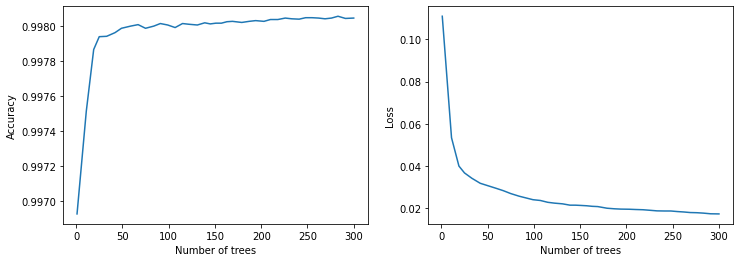

In [78]:
#make a function to plot the accuracy for number of trees
def plot_curve(logs):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Loss")

    plt.show()

#showing the improvement of accuracy by the number of tree
plot_curve(logs_tf_rf)

#As it can be seen, the accuracy improves as the number of trees increased

In [79]:
print("model_1 summary: ")
print(model_tf_rf.summary())
print()

model_1 summary: 
Model: "random_forest_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (42):
	acc_now_delinq_index
	annual_inc
	application_type_index
	collection_recovery_fee
	collections_12_mths_ex_med_imputed
	delinq_2yrs
	dti
	emp_length_index
	funded_amnt
	funded_amnt_inv
	grade_index
	home_ownership_index
	id
	initial_list_status_index
	inq_last_6mths
	installment
	int_rate
	last_pymnt_amnt_imputed
	loan_amnt
	member_id
	open_acc
	out_prncp
	out_prncp_inv
	policy_code_imputed
	pub_rec
	purpose_index
	pymnt_plan_index
	recoveries
	revol_bal
	revol_util_imputed
	sub_grade_index
	term_index
	tot_coll_amt_imputed
	tot_cur_bal_imputed
	total_acc
	total_pymnt
	total_pymnt_inv
	total_rec_int
	total

In [80]:
loss_rf, precision_rf, recall_rf, accuracy_rf = model_tf_rf.evaluate(tf_test)
print("Random Forest Tensorflow Evaluation: \n")
print("loss", loss_rf)
print("precision", precision_rf)
print("recall", recall_rf)
print("accuracy", accuracy_rf)

f1_score_rf = 2 * ((precision_rf * recall_rf) / (precision_rf + recall_rf))
print("f1 score", f1_score_rf)

258/258 [==============================] - 15s 55ms/step - loss: 0.0000e+00 - precision: 0.9999 - recall: 0.9640 - accuracy: 0.8551
Random Forest Tensorflow Evaluation: 

loss 0.0
precision 0.9998508095741272
recall 0.9640417098999023
accuracy 0.8551325798034668
f1 score 0.9816197928843833


Precision is the ratio of TP / (TP+FP). TP means the data that are correctly classified. Meanwhile, False Positive (FP) means the data that should not be classified to this class, but they are classified to this class. In short, the (TP+FP) means the total number of correct data that should be classified as that class. It measures the quality of the model.

Recall means the ratio of TP / (TP+FN). False negative is the data that are classified to this class, but they are predicted to other class. Then, it is used to calculate the True Positive recognition rate. This made of all the positive values in the dataset.


F1-score is the combination between the precision and recall. It compares in which class does the classifier works better. 

In [81]:
prob_tf_rf = (model_tf_rf.predict(tf_test))
y_pred_tf_rf = prob_tf_rf.round(0)

258/258 [==============================] - 15s 56ms/step


**2. Decision Tree** 

what makes decision tree and random forest different?

Decision tree means there is only one tree, and random forest is a group of decision tree combined into 1.

In [82]:
#only 1 tree is used for this decision tree
model_tf_dt = tfdf.keras.RandomForestModel(verbose=2, num_trees = 1, max_depth = 700, min_examples = 10)



# Train the model.
model_tf_dt.compile(metrics= [metrics.Precision(name="precision"),
                              metrics.Recall(name="recall"),
                              metrics.Accuracy(name="accuracy")])

Use 2 thread(s) for training
Use /tmp/tmp4cnqh_55 as temporary training directory


In [83]:
model_tf_dt.fit(tf_train)

Reading training dataset...
Training tensor examples:
Features: {'id': <tf.Tensor 'data_12:0' shape=(None,) dtype=int32>, 'member_id': <tf.Tensor 'data_19:0' shape=(None,) dtype=int32>, 'loan_amnt': <tf.Tensor 'data_18:0' shape=(None,) dtype=int32>, 'funded_amnt': <tf.Tensor 'data_8:0' shape=(None,) dtype=int32>, 'funded_amnt_inv': <tf.Tensor 'data_9:0' shape=(None,) dtype=float64>, 'int_rate': <tf.Tensor 'data_16:0' shape=(None,) dtype=float64>, 'installment': <tf.Tensor 'data_15:0' shape=(None,) dtype=float64>, 'annual_inc': <tf.Tensor 'data_1:0' shape=(None,) dtype=int32>, 'dti': <tf.Tensor 'data_6:0' shape=(None,) dtype=float64>, 'delinq_2yrs': <tf.Tensor 'data_5:0' shape=(None,) dtype=int32>, 'inq_last_6mths': <tf.Tensor 'data_14:0' shape=(None,) dtype=int32>, 'open_acc': <tf.Tensor 'data_20:0' shape=(None,) dtype=int32>, 'pub_rec': <tf.Tensor 'data_24:0' shape=(None,) dtype=int32>, 'revol_bal': <tf.Tensor 'data_28:0' shape=(None,) dtype=int32>, 'total_acc': <tf.Tensor 'data_34:0'

[INFO kernel.cc:813] Start Yggdrasil model training
[INFO kernel.cc:814] Collect training examples
[INFO kernel.cc:422] Number of batches: 479
[INFO kernel.cc:423] Number of examples: 478871
[INFO kernel.cc:836] Training dataset:
Number of records: 478871
Number of columns: 43

Number of columns by type:
	NUMERICAL: 42 (97.6744%)
	CATEGORICAL: 1 (2.32558%)

Columns:

NUMERICAL: 42 (97.6744%)
	0: "acc_now_delinq_index" NUMERICAL mean:0.00494705 min:0 max:5 sd:0.0759907
	1: "annual_inc" NUMERICAL mean:75081.5 min:0 max:9.5e+06 sd:67719.6
	2: "application_type_index" NUMERICAL mean:0.000501179 min:0 max:1 sd:0.0223814
	3: "collection_recovery_fee" NUMERICAL mean:4.97791 min:0 max:7002.19 sd:62.9288
	4: "collections_12_mths_ex_med_imputed" NUMERICAL mean:0.0143838 min:0 max:20 sd:0.135243
	5: "delinq_2yrs" NUMERICAL mean:0.310261 min:0 max:29 sd:0.850834
	6: "dti" NUMERICAL mean:18.1606 min:0 max:9999 sd:22.0964
	7: "emp_length_index" NUMERICAL mean:3.52583 min:0 max:11 sd:3.56632
	8: "fun

Model trained in 0:00:04.064031
Compiling model...
Model compiled.


In [84]:
loss_dt, precision_dt, recall_dt, accuracy_dt = model_tf_dt.evaluate(tf_test)

258/258 [==============================] - 10s 36ms/step - loss: 0.0000e+00 - precision: 0.9829 - recall: 0.9559 - accuracy: 0.9967


In [85]:
#view the accuracy, loss, precision, and recall values for evaluation decision tree
print("loss", loss_dt)
print("precision", precision_dt)
print("recall", recall_dt)
print("accuracy", accuracy_dt)

f1_score_dt = 2 * ((precision_dt * recall_dt) / (precision_dt + recall_dt))
print("f1 score", f1_score_dt)

loss 0.0
precision 0.9829179644584656
recall 0.9559151530265808
accuracy 0.9967163801193237
f1 score 0.9692285199116795


In [86]:
logs_tf_dt = model_tf_dt.make_inspector().training_logs()
print(logs_tf_dt)

[TrainLog(num_trees=1, evaluation=Evaluation(num_examples=176494, accuracy=0.9965041304520267, loss=0.12600390395911537, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None))]


### 3. Gradient Boosted Trees

In [87]:
#Calling the function for the gradient boosted trees
model_1 = tfdf.keras.GradientBoostedTreesModel()

Use /tmp/tmp6k68v9o_ as temporary training directory


In [88]:
#training the train dataset
model_1.fit(tf_train)

Reading training dataset...
Training dataset read in 0:00:15.822357. Found 478871 examples.
Training model...
Model trained in 0:21:36.469135
Compiling model...
Model compiled.


In [89]:
model_1.compile(metrics=["accuracy"])

In [90]:
#Evaluate the test data set
evaluation = model_1.evaluate(tf_test)
print(evaluation)

258/258 [==============================] - 10s 38ms/step - loss: 0.0000e+00 - accuracy: 0.9980
[0.0, 0.9979885816574097]


In [91]:
model_1.make_inspector().evaluation()

Evaluation(num_examples=None, accuracy=0.9981286525726318, loss=0.01748514175415039, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)

In [92]:
model_1.make_inspector().variable_importances()

{'NUM_NODES': [("total_rec_prncp" (1; #39), 853.0),
  ("last_pymnt_amnt_imputed" (1; #17), 723.0),
  ("id" (1; #12), 684.0),
  ("installment" (1; #15), 481.0),
  ("total_rec_int" (1; #37), 460.0),
  ("total_rec_late_fee" (1; #38), 420.0),
  ("out_prncp_inv" (1; #22), 366.0),
  ("out_prncp" (1; #21), 327.0),
  ("total_pymnt" (1; #35), 240.0),
  ("funded_amnt" (1; #8), 236.0),
  ("total_pymnt_inv" (1; #36), 230.0),
  ("member_id" (1; #19), 177.0),
  ("funded_amnt_inv" (1; #9), 169.0),
  ("dti" (1; #6), 152.0),
  ("annual_inc" (1; #1), 151.0),
  ("int_rate" (1; #16), 149.0),
  ("tot_cur_bal_imputed" (1; #33), 117.0),
  ("total_rev_hi_lim_imputed" (1; #40), 98.0),
  ("revol_bal" (1; #28), 93.0),
  ("revol_util_imputed" (1; #29), 89.0),
  ("loan_amnt" (1; #18), 85.0),
  ("recoveries" (1; #27), 84.0),
  ("total_acc" (1; #34), 69.0),
  ("open_acc" (1; #20), 62.0),
  ("inq_last_6mths" (1; #14), 48.0),
  ("purpose_index" (1; #25), 48.0),
  ("tot_coll_amt_imputed" (1; #32), 47.0),
  ("sub_grade_

In [93]:
#predicting the test dataset
probs = (model_1.predict(tf_test))
y_pred = probs.round(0)

258/258 [==============================] - 10s 39ms/step


In [98]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    243130
           1       1.00      0.97      0.98     13905

    accuracy                           1.00    257035
   macro avg       1.00      0.98      0.99    257035
weighted avg       1.00      1.00      1.00    257035



### 4. FeedForward Neural Network

In [102]:
#Create a Feedforward Neural Network
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[42,]))
model.add(keras.layers.Dense(50, activation="relu", kernel_regularizer=keras.regularizers.L1L2(l1=0.001, l2 = 0.001)))
model.add(keras.layers.Dense(50, activation="relu"))
# model.add(keras.layers.Dense(40, activation="tanh"))
# model.add(keras.layers.Dense(40, activation="tanh"))
#this is the output layer
#softmax is used because it can calculate the distribution of probabilities
model.add(keras.layers.Dense(2, activation="softmax"))

In [103]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                2150      
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 2)                 102       
                                                                 
Total params: 4,802
Trainable params: 4,802
Non-trainable params: 0
_________________________________________________________________


In [104]:
#compile the model 
sgd = keras.optimizers.SGD(lr=0.01, clipnorm=1.)
model.compile(loss="sparse_categorical_crossentropy",
#use the gradient descent as the optimizer (change the weight and learning rate to reduce loss)
#set the learning rates
 optimizer= sgd,
#metrics to calculate the performance of the model during training and validation
 metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [107]:
#try to fit the training model into the model. 
n_epochs = 130
history_validation = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), epochs=n_epochs)

Epoch 1/130
14965/14965 [==============================] - 45s 3ms/step - loss: 15453.1367 - accuracy: 0.8832 - val_loss: 0.3811 - val_accuracy: 0.9461
Epoch 2/130
14965/14965 [==============================] - 37s 2ms/step - loss: 51.2634 - accuracy: 0.9351 - val_loss: 0.2108 - val_accuracy: 0.9462
Epoch 3/130
14965/14965 [==============================] - 37s 2ms/step - loss: 62.6185 - accuracy: 0.9318 - val_loss: 0.2740 - val_accuracy: 0.9462
Epoch 4/130
14965/14965 [==============================] - 38s 3ms/step - loss: 99.9990 - accuracy: 0.9268 - val_loss: 0.2126 - val_accuracy: 0.9462
Epoch 5/130
14965/14965 [==============================] - 43s 3ms/step - loss: 149.9876 - accuracy: 0.9257 - val_loss: 0.2103 - val_accuracy: 0.9462
Epoch 6/130
14965/14965 [==============================] - 44s 3ms/step - loss: 190.4378 - accuracy: 0.9270 - val_loss: 0.2100 - val_accuracy: 0.9462
Epoch 7/130
14965/14965 [==============================] - 41s 3ms/step - loss: 349.4767 - accuracy: 

(0.0, 1.0)

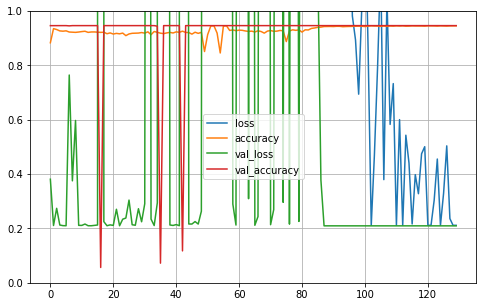

In [108]:
pd.DataFrame(history_validation.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)

In [109]:
#do the evaluation on the testing set
model.evaluate(x_test)

8033/8033 [==============================] - 17s 2ms/step - loss: 7.1599e-06 - accuracy: 0.0000e+00


[7.159947926993482e-06, 0.0]

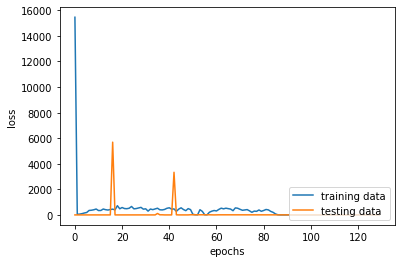

In [111]:
plt.plot(history_validation.history["loss"])
plt.plot(history_validation.history["val_loss"])
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend(["training data", "testing data"], loc = "lower right")
plt.show()

As it can be seen from graph above, there is a little improvement from the first epoch. However, it is kind of does not improve at some point.

### 5. SVM

In [113]:
#making the session
sess = tf1.Session()

In [115]:
batch_size = 100

#There are 42 features (columns) that are utilized for the model
#these placeholders serves to contain fed data that will be use for computational purpose
x_data = tf1.placeholder(shape=[None, 42], dtype=tf.float32)
y_target = tf1.placeholder(shape=[None, 1], dtype=tf.float32)

#Create model variables which are slope and constant of the linear equation
#that are initialized when session starts and the values get adjusted to find the best fit line 
#or hyperplane by maximizing the margin which classifies the prediction
A = tf1.Variable(tf1.random_normal(shape=[42,1]))
b = tf1.Variable(tf1.random_normal(shape=[1,1]))

In [116]:
#model output declaration
model_output = tf1.subtract(tf1.matmul(x_data, A), b)
#the feature data is multiplied with the intercept variable and the result is subtracted with the constant variable for the output

In [118]:
#maximum margin loss
l2_norm = tf1.reduce_sum (tf1.square(A))

#alpha determine whether the margin crossing the margin line will be a soft of hard allowance
#the larger the value the more emphasis on widening the margin 
#the smaller  the values result in the model having a hard margin while allowing data points to cross the margin 
alpha = tf1.constant([0.1])
classification_term = tf1.reduce_mean(tf1.maximum(0.,tf1.subtract(1.,tf1.multiply(model_output, y_target))))

#loss function
loss = tf1.add(tf.multiply(alpha, l2_norm), classification_term)

In [120]:
#prediction and accuracy
prediction = tf1.sign(model_output)
accuracy = tf1.reduce_mean(tf1.cast(tf1.equal(prediction, y_target), tf1.float32))

In [121]:
#declare optimizer and initialize model variables
my_opt = tf1.train.GradientDescentOptimizer(0.01)
train_step = my_opt.minimize(loss)

#initialize variables
init = tf1.global_variables_initializer()
sess.run(init)

In [124]:
x_test_values = (df_test.toPandas()).iloc[:,0:42].values
y_test_values = (df_test.toPandas()).iloc[:,-1].values
x_train_values = (df_train.toPandas()).iloc[:,0:42].values
y_train_values = (df_train.toPandas()).iloc[:,-1].values

In [125]:
#training loop 
import numpy as np
#Storing values for data visualization later on
loss_vec = []
train_acc = []
test_acc = []

for i in range(1000):
  rand_index = np.random.choice(len(x_train_values), size=batch_size)
  rand_x = x_train_values[rand_index]
  rand_y = np.transpose([y_train_values[rand_index]])
  sess.run(train_step, feed_dict = {x_data: rand_x, y_target:rand_y})

  temp_loss = sess.run(loss, feed_dict = {x_data: rand_x, y_target:rand_y})
  loss_vec.append(temp_loss)

  train_acc_temp = sess.run(accuracy, feed_dict = {x_data: x_train_values, y_target: np.transpose([y_train_values])})
  train_acc.append(train_acc_temp)

  test_acc_temp = sess.run(accuracy, feed_dict={
      x_data:x_test_values,
      y_target: np.transpose([y_test_values])})
  test_acc.append(test_acc_temp)

  if (i+1) % 100 == 0:
    # print('Step #{} A = {}, b = {}'.format(
    #     str(i+1),
    #     str(sess.run(A)),
    #     str(sess.run(b))
    # ))
    print('Accuracy = ' + str(train_acc_temp))
    print('Loss = ' + str(temp_loss))

Accuracy = 0.054467697
Loss = [3.5538898]
Accuracy = 0.054467697
Loss = [2.7217453]
Accuracy = 0.054467697
Loss = [2.1339626]
Accuracy = 0.054467697
Loss = [1.7934175]
Accuracy = 0.054467697
Loss = [1.5050316]
Accuracy = 0.054467697
Loss = [1.3351994]
Accuracy = 0.054467697
Loss = [1.1747024]
Accuracy = 0.054467697
Loss = [1.1339633]
Accuracy = 0.054467697
Loss = [1.0598638]
Accuracy = 0.054467697
Loss = [1.0236144]


In [126]:
[[a1],[a2],[a3],[a4],[a5],[a6],[a7],[a8],[a9],[a10],[a11],[a12],[a13],[a14],[a15],[a16],[a17],[a18],[a19],[a20],[a21],[a22],[a23],[a24],[a25]
 ,[a26],[a27],[a28],[a29],[a30],[a31],[a32],[a33],[a34],[a35],[a36],[a37],[a38],[a39],[a40],[a41],[a42]]= sess.run(A)
slope = -a2/a1
y_intercept = b/a1
x1_test = [d[1] for d in x_test_values]
best_fit = []
for i in x1_test:
  best_fit.append(slope*i+y_intercept)
yes_loan_x = [d[1] for i, d in enumerate(x_test_values) if y_test_values[i] == 1]
yes_loan_y = [d[0] for i, d in enumerate(x_test_values) if y_test_values[i] == 1]
no_loan_x = [d[1] for i, d in enumerate(x_test_values) if y_test_values[i] == -1]
no_loan_y = [d[0] for i, d in enumerate(x_test_values) if y_test_values[i] == -1]

#best_fit

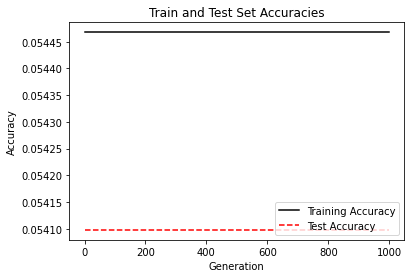

In [127]:
# plotting the accuracy based on the train and test
plt.plot(train_acc, 'k-', label= 'Training Accuracy')
plt.plot(test_acc, 'r--', label='Test Accuracy')
plt.title('Train and Test Set Accuracies')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

As it can be seen from the figure above, the accuracy is pretty low which is aroudn 0.05 and there is no improvement. Therefore, this model is not suitable with the data type that we have for this problem.

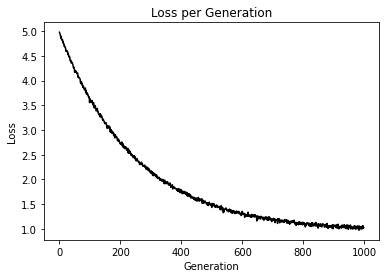

In [128]:
plt.plot(loss_vec, 'k-')
plt.title('Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()